# Open Addressing HashMaps

I recently stumbled across the wild world of hashmaps when I was writing a chapter about how dictionaries are implemented in Python and fell down a pretty deep rabbit hole. Intruiged, I set out to determine whether I myself could write a hashmap faster that would rival or potentially even surpass the performance of *std::unordered_map*.

## Hashmap Basics

In case you aren't familiar with the inner workings of a hashmap, hashmaps are essentially big look-up tables that store key-value pairs. The way they work is they take a key and plug it into a hash function. A hash function is a function that takes an object and spits out some number that corresponds to that object. You then take that hash value and convert it into an index, usually using a modulo operation. Then you just stick the key-value pair into that index in your look-up table.

What makes hashmaps different from eachother is how they deal with hash collisions. Ideally, your hash function will be perfectly random and evenly distributed. However, sometimes two objects will have the same hash, which is bad news bears. If they have the same hash, then they get sent to the same index. Something else that can happen is if your hashmap look-up table is of small size, then multiple different hashes can get converted to the same index. These are called hash collisions, since the hash values and their indices collide for different keys. Below I describe different implementations, how they deal with hash collisions, and their pros and cons.


## The Operations

When implementing my hashmaps, I focused on 3 main functions:

1. **void insert(K& const key, V& const value)**: Takes a key and a value and inserts a new pair into the hashmap

2. **bool emplace(K const &key, V &value)**: Takes a key and a value variable and queries the hashmap. If the value does exist, the function writes the corresponding value to the given value variable and returns true. If the value doesn't exist, then the function returns false.

3. **bool remove(K const &key)**: Takes a key and queries the hashmap. If the value exists, then the hashmap removes the entry and the function returns true. If the value doesn't exist, then the function returns false.

I refer to emplace and look-ups interchangeably, since they're essentially the same thing, except emplace as a function is easier to debug.

## Worst-Case vs. Average-Case

Hashmaps are known to have $O(N)$ worst case complexities, since it's easy to construct a malicious test case that causes a hashmap to look through all of the entries in the map. What's more interesting is the average worst-case performance. When I use Big-O notation in this article, it will refer to average worst-case performance. What I mean by average worst-case performance is we'll look at worst-cases for each function assuming perfectly randomly uniform hashes. The great thing about average-case performance is that you can use expected value for calculations.



## std::unordered_map

### The Implementation
*std::unordered_map* uses a technique called separate chaining to build its hashmap. You can think of the underlying structure of *std::unordered_map* as a static array with buckets of linked lists that hold key-value pairs. When a new key-value pair needs to be inserted into the hashmap, *std::unordered_map* takes the key, hashes it, and converts the hash into an index. *std::unordered_map* then goes to its table, finds the index, and checks whether a key or keys already live there. If the index is empty, then the table simply inserts the key-value pair. However, if there are multiple keys, then *std::unordered_map* will check all of the keys that live there already to determine if the key already exists. If it does, then it only changes the value. If it doesn't, then *std::unordered_map* will insert the new key-value pair into a chain of other key-value pairs in the form of a linked-list. When a key-value pair needs to be removed, the map iterates over that bucket's linked list and splices out the key-value pair if it is found.

### Theoretical Performance

#### Average-Case Behavior

Let the total number of buckets (i.e the capacity of the hashmap) be $K$ and let the total number of entries be $N$. Suppose we assume our hash function has a perfectly uniform distribution. That is, suppose that for every possible object, the probability of it hashing to any bucket is the same. Then the probability that an object hashes to a bucket $i$ is $\frac{1}{K}$ and the expected number of entries per bucket is $N \cdot \frac{1}{K} = \frac{N}{K}$.

When we insert, we first have to search every single value in the bucket, so the average-case performance is $O\left(\frac{N}{K}\right)$. This seems like it's linear, but we can say it's amortized O(1) if $\frac{N}{K} \approx C$, where $C$ is some constant. Thus, we can achieve amortized O(1) when $N \approx CK$, which can be maintained by rehashing and expanding the number of buckets to compensate when $N$ gets too high. The time complexity for look-ups and removals is very similar.

#### Pros and Cons of Chaining
Chaining is a very simple method to ensure that keys are safely kept in the bucket they're assigned to. In addition, since we can grow the linked list to infinite length, technically we can never run out of space in our hashmap. The static array does not need to be grown. However, this does come with some significant drawbacks. In the case that elements are mapped to a small range of indices, there's a lot of wasted space in the hashmap. Cache performance is also not great with linked lists, since linked list nodes are not (necessarily) adjacent in memory. As you iterate along the chain, you run into a bunch of cache misses bouncing across memory addresses, which slows down search.

Our goal is to minimize wasted space and improve cache performance of searches with the following hashmap implementations.

## LinearMap

### The Implementation

The first hashmap I implemented uses open addressing with linear probing, which I called LinearMap. The idea of open addressing is that key-value pairs can live in slots that it does not necessarily map to. The underlying structure is an array of objects of type `Entry<K, V>`. Each entry stores the key, the value, the hash value of the key, and some other book keeping items. Suppose you want to insert a key-value pair, and the key hashes to index 21. But in index 21, there already exists a key-value pair. Instead of chaining, what we do is we "probe" for an empty slot and stick it in there instead. There are a bunch of different probing schemes out there, but the simplest is linear probing, which means we just scan the array linearly for the next available slot. When we want to look-up a value, we go to the initial bucket that the key hashes to and check if that slot contains the key. If the slot doesn't contain that key, then we continue to probe the same way we did looking for an empty slot. 

When it comes to deletion, there are two main methods. The first method is called the "Tombstone" method. Tombstones are markers that denote entries that have been used but are now empty since the key value pair has been removed. This makes removals super easy since you just mark them as a tombstone and get on with your day. When you insert values into the hashmap, you can insert them into tombstones. However, when you look up values, you have to skip over tombstones and keep looking because if you stop when you get to a tombstone, there's the possibility that a key that you had added after the deleted key can no longer be reached when probing from the start index. For example, consider if we have a hashmap of size 8, and we hash the key-value pairs (0, 1), (8, 1), (16, 1), and (32, 1). With an array of size 8, we end up having each of these keys hash to index 0. Linear probing would cause us to place each of the collided key-value pairs into indices 1, 2, and 3 instead. Suppose we delete the key-value pair (8, 1). Then if we mark it as empty and try to look up if 32 or 16 exists in the hashmap, then we would begin probing from index 0 until we meet index 1, which we see as "empty". Then we would incorrectly assume that the keys 32 or 16 do not exist in the hashmap, when in fact they do exist in the hashmap, only farther down into the array. Thus, marking the slot as a tombstone rather than empty is imperative to correct look-up behavior with removals. Later, when we try to insert a new key, we can insert into a tombstone instead of the empty slot that terminated the probe.

The second method is backwards shifting. I have not yet found an online resource that describes a method for backwards shifting on a hashmap that isn't a Robinhood hashmap, but I modified the original backwards shifting algorithm to work for regular linear probed maps. Essentially, when we remove an entry, there exists an empty hole. We will continue to move entries down until the hole has been filled in completely. For example, in the previous example, if we remove the key-value pair (8, 1), we move the entry (16, 1) into (8, 1) and then (32, 1) into the slot that used to hold (16, 1). This fixes the holes in the hashmap, restores the linear probing sequence and removes the need to use tombstones! The one thing we do need to make sure is check that the entry we are trying to move backwards won't be moved further past its original slot. If it would be, then we move onto the next one.

### Theoretical Performance

#### Average Case Performance

However, like I said, we deal with average-case complexity. To talk about performance with open-addressed maps, we introduce the idea of a probe sequence length, or PSL. The probe sequence length is how far in terms of slots you have to probe starting from the index that a key originally hashes to in order to get to the key in question. 

In order to calculate the average PSL of a linear hashmap, let's first analyze the average case performance of insertions. The worst case for an insertion is where the key is new to the hashmap, since it has to look through the entire probe sequence. Let $K$ be the number of slots in the hashmap, $N$ be the number of key-value pairs, and $T$ be the number of tombstones. Under the assumption of a perfectly random hash function, each entry in the array has a probability $\frac{N}{K}$ of being occupied by a key-value pair, a probability $\frac{T}{K}$ of being a tombstone, and a probability $\frac{K - \left(N+T\right)}{K}$ probability of being completely empty. The average PSL can then be calculated as the expected number of contiguous slots that aren't empty. This follows a geometric distribution, parametrized by the probability of finding an empty slot, $\frac{K - \left(N+T\right)}{K}$, giving an expected PSL of $\frac{K}{K - \left(N+T\right)}$. With the backwards shifting method, the number of tombstones is zero, giving an expected PSL of $\frac{K}{K - N}$.

We can now describe the performance of look-ups and removals in terms of PSLs. Since unsuccessful look-ups have to look through the entire probe sequence as well, we can say that the average worst-case performance is $O\left(\frac{K}{K - \left(N+T\right)}\right)$. For removals, if we use the tomb-stone method, then the average worst-case performance is $O\left(\frac{K}{K - \left(N+T\right)}\right)$ as well. If we use the backwards shift method, then the worst-case performance is when we have to swap the entire probe sequence backwards. However, with backwards shifting, there doesn't exist any tombstones, so $T = 0$ yielding an average worst-case performance is actually $O\left(\frac{K}{K - N}\right)$.

#### Pros and Cons of Open Addressing

Since all of the entries are placed next to one another in a flat array, this means that cache performance should be better. However, with tombstones, it's possible that interleaving insertions and removals results in longer probe sequences the linked list would have, as mentioned above. According to this [stackoverflow post](https://stackoverflow.com/questions/47781316/linked-list-vs-array-traversal-efficiency), following pointer indirection takes 4 times as many cycles as calculating the next address in an array. I don't know how correct this is, but I do know that pointer indirection takes more cycles than calculating the next address in the array, so let's call this factor $C$.

However, under the assumption of a perfectly uniform hashmap, we previously calculated that there would be average of $\frac{N}{K}$ entries in a list. The worst-case scenario would be having to follow every single entry in an unsuccessful look-up. We can calculate when the performance of separate chaining is worse than the performance of open addressing as follows:

$$\begin{gather}
C\frac{N}{K} > \frac{K}{K - N} \\
\frac{CN\left(-N+K\right)-K^2}{-N+K}>0 \\
N>K
\end{gather}$$


Notice that since we must have that $N < K$, this inequality is actually never satisfied. This means that for the same number of buckets, open addressing is actually worse than chaining. However, the opposite is true as well: as soon as you have $N > K$ in a chained hashmap, your performance using chaining is actually worse. Of course, since we can never have $N > K$ for open addressed hashmaps, then open addressed hashmaps are actually quite space inefficient relative to their chained hashmap counterparts. 

## Robinhood Map

### Implementation

Robinhood hashing is a simple twist on linear probing designed to reduce the variance of the probe sequence lengths in the hashmap and improve average-case performance. The idea is when you linearly probe, you check the PSL of the current index against the current PSL. If the current index has a smaller PSL, then you swap your current key-value pair into the current index and continue along your probe. If you imagine that indices with lower PSLs are richer since they're closer to their original index and indices with higher PSLs are poorer for the opposite reason, the name "Robinhood Hashing" becomes pretty clever.

This gives the underlying array some unique properties. One, the underlying array is sorted by key by PSL, since we always bump lower PSL entries down the array. Two, the variance of PSLs becomes much smaller, since we split the PSLs across multiple entries. This gives it better constant time. However, it does not reduce the average PSL in the hashmap. In fact, my robinhood hashmap and my linear map will always have the same average PSL. This is because when you swap two values, the combined PSL of those two entries remains the same, which means the total PSL sum of the map is constant, no matter the ordering of the entries. All that changes is the variance.

### Theoretical Performance

The theoretical performance of Robinhood hashing is pretty hard to mathematically derive. From intuition, it seems that it will have a better average worst-case performance since the max PSL in the hashmap has been decreased. But we'll just have to see what happens in the actual hashmap

## Benchmark Results

All benchmark tests were run using default sizes of 1024 slots with load factors of 0.5. All generated integers were of type `uint64_t`. The hash function used was just the identity function for integers in order to better compare operation speeds rather than hash function speed.

First, we run the benchmark speed and memory usage tests and load in the CSV files:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

benchmarks_dir = './benchmarks/'
benchmark_names = ['insert', 'emplace', 'unsuccessful_emplace', 'remove', 'insert_with_removal', 'emplace_with_removal', 'unsuccessful_emplace_with_removal']
graph_names = ['insert', 'emplace', 'unsuccessful_emplace', 'remove', 'insert_with_removal', 'emplace_with_removal', 'unsuccessful_emplace_with_removal']
hashmap_names = ['LMap+TS', 'LMap+BS', 'RMap', 'UMap']

speedup_names = []
for hname in hashmap_names:
    new_col = "{} Speed-Up".format(hname)
    speedup_names.append(new_col)

pds = {}

for bname in benchmark_names:
    new_df = pd.read_csv(benchmarks_dir + bname + '.csv')
    
    for hname in hashmap_names:
        new_col = "{} Speed-Up".format(hname)
        new_df[new_col] = new_df['UMap'] / new_df[hname] 
        
    pds[bname] = new_df

### Simple Insertion

This test generates a vector of keys from 0 to $K$, shuffles them into a random order, then records the time it takes to insert all of the keys into the hashmap:

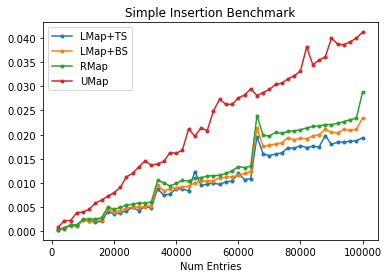

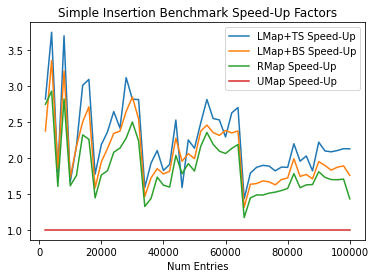

In [2]:
pds['insert'].plot(x = 'Num Entries', 
                   y = hashmap_names, 
                   title = "Simple Insertion Benchmark", 
                   style='.-')
plt.show()
pds['insert'].plot(x = 'Num Entries',
                   y = speedup_names,
                   title = "Simple Insertion Benchmark Speed-Up Factors")
plt.show()

As we can see, *std::unordered_map* on average performs the worst, increasing at the fastest rate. The performances of all my maps seem to have roughly the same performance, with LinearMap with tombstones performing the best out of all my implementations.

### Simple Successful Look-Up

This test generates a vector of keys from 0 to $K$, squares each value, shuffles them into a random order, and then inserts the keys into the hashmap. Then it shuffles the keys into a random order again and records the time it takes to look up all of the keys in the vector.

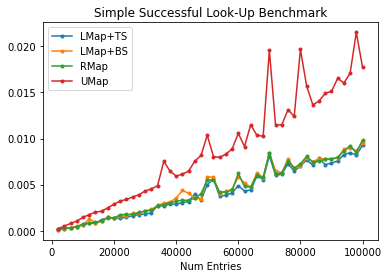

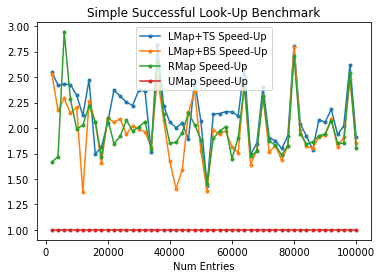

In [3]:
pds['emplace'].plot(x = 'Num Entries', 
                    y = hashmap_names, 
                    title = "Simple Successful Look-Up Benchmark", 
                    style='.-')
plt.show()

pds['emplace'].plot(x = 'Num Entries', 
                    y = speedup_names, 
                    title = "Simple Successful Look-Up Benchmark", 
                    style='.-')
plt.show()

As expected, we can see that *std::unordered_map* performs the worst. Interestingly, it appears *LinearMap* with tombstones is consistently faster than the backwards shifting variants, despite their emplace() function implementations being virtually the same.

### Simple Unsuccessful Look-Up

This test generates a random vector of posisble keys from 0 to $K$, adds $K$, shuffles them into a random order, and then inserts the keys into the hashmap. Then it shuffles the keys into a random order again and records the time it takes to look up all of the keys in the vector.

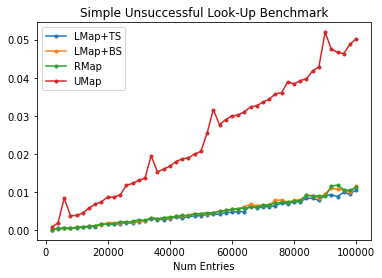

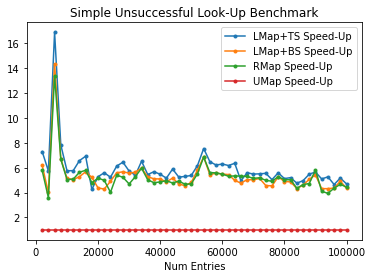

In [4]:
pds['unsuccessful_emplace'].plot(x = 'Num Entries', 
                                 y = hashmap_names, 
                                 title = "Simple Unsuccessful Look-Up Benchmark", 
                                 style='.-')
plt.show()

pds['unsuccessful_emplace'].plot(x = 'Num Entries', 
                                 y = speedup_names, 
                                 title = "Simple Unsuccessful Look-Up Benchmark", 
                                 style='.-')
plt.show()

We see the exact same story here, with tombstones outperforming backwards shifting very slightly.

### Simple Removal

This test generates a random vector of possible keys from 0 to $K$, squares each value, shuffles them into a random order, then inserts the keys into the hashmap. Then it shuffles the keys into a random order again and records the time it takes to remove all of the keys in the vector in the new shuffled order. 

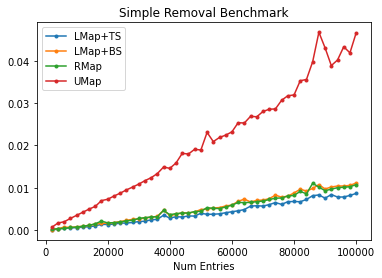

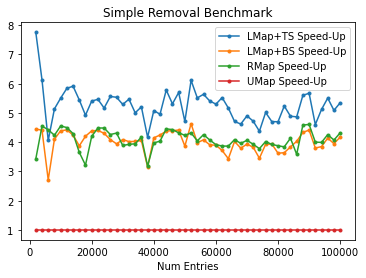

In [5]:
pds['remove'].plot(x = 'Num Entries', 
                    y = hashmap_names, 
                    title = "Simple Removal Benchmark", 
                    style='.-')
plt.show()

pds['remove'].plot(x = 'Num Entries', 
                    y = speedup_names, 
                    title = "Simple Removal Benchmark", 
                    style='.-')
plt.show()

Once again, *std::unordered_map* proves to be the slowest method with tombstones outperforming backwards shifting. In this case, it makes a lot of sense that tombstones would be incredibly fast, since backwards shifting requires iterating over multiple entries in the list whereas tombstones only has to mark a single entry as a tombstone.

### Insertions with Removals

This test generates a random vector of possible keys from 0 to $K$, shuffles them into a random order, then inserts the keys into the hashmap. Then it shuffles half of the randomized keys into a random order again and removes those keys from the hashmap. Finally, all the keys are shuffled into a random order and the test records the time it takes to insert all of the keys in the vector.

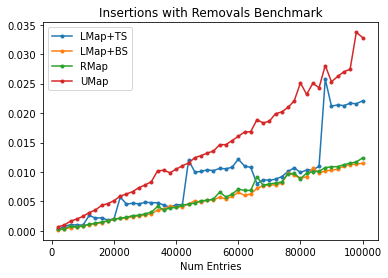

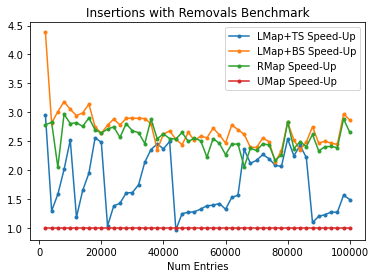

In [6]:
pds['insert_with_removal'].plot(x = 'Num Entries', 
                                y = hashmap_names, 
                                title = "Insertions with Removals Benchmark", 
                                style='.-')
plt.show()

pds['insert_with_removal'].plot(x = 'Num Entries', 
                                y = speedup_names, 
                                title = "Insertions with Removals Benchmark", 
                                style='.-')
plt.show()

We now see a much different story. Tombstone removal is now the slowest implementation. This makes sense, since tombstones cause longer probe sequence chains. We can also see huge spikes with the that eventually go down until they spike again. The distance between spikes seems to double every time, as well as the peak. This is most likely due to the fact that the hashmap reallocates itself to keep constant time performance, but before it hits the threshold, there exist too many tombstones causing performance to degrade. 

Interestingly,*LinearMap* with backwards shifting is the fastest and most consistent performing hashmap out of the 4. Robinhood hashing theoretically should be outperforming *LinearMap* in this benchmark, but it appears that the overhead of swaps combined with the fact that both employ backwards shifting allows *LinearMap* to enjoy a comfortable lead above Robinhood Hashing, albeit only a slight lead.

### Successful Look-Ups with Removals

This test generates a vector of keys from 0 to $K$, squares each value, shuffles them into a random order, then inserts the keys into the hashmap. Then it shuffles half of the randomized keys into a random order again and removes those keys from the hashmap. Finally, all the keys are shuffled into a random order and the test records the time it takes to look-up all of the keys in the vector.

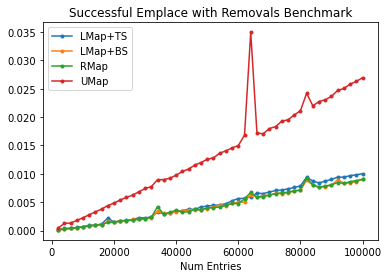

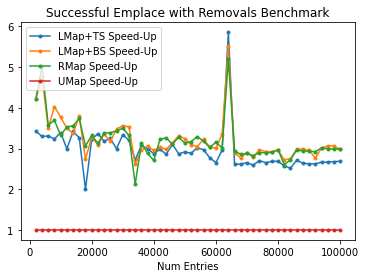

In [7]:
pds['emplace_with_removal'].plot(x = 'Num Entries', 
                                y = hashmap_names, 
                                title = "Successful Emplace with Removals Benchmark", 
                                style='.-')
plt.show()

pds['emplace_with_removal'].plot(x = 'Num Entries', 
                                y = speedup_names, 
                                title = "Successful Emplace with Removals Benchmark", 
                                style='.-')
plt.show()

Once again, tombstones are the slowest of the open-addressed maps, with *RobinhoodMap* and *LinearMap* being neck and neck in performance.

### Unsuccessful Look-Ups with Removals

This test generates a vector of keys from 0 to $K$, squares each value, shuffles them into a random order, then inserts the keys into the hashmap. Then it shuffles half of the randomized keys into a random order again and removes those keys from the hashmap. Finally, all the keys are shuffled into a random order and the test records the time it takes to look-up all of the keys in the vector.

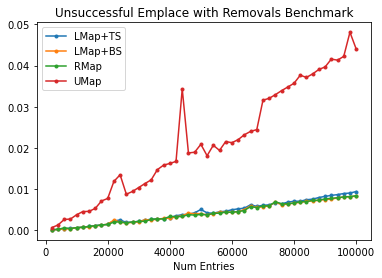

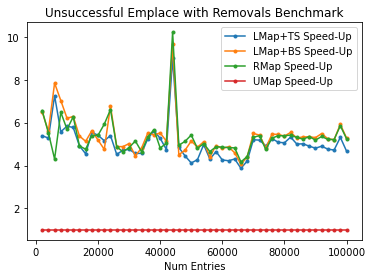

In [8]:
pds['unsuccessful_emplace_with_removal'].plot(x = 'Num Entries', 
                                y = hashmap_names, 
                                title = "Unsuccessful Emplace with Removals Benchmark", 
                                style='.-')
plt.show()

pds['unsuccessful_emplace_with_removal'].plot(x = 'Num Entries', 
                                y = speedup_names, 
                                title = "Unsuccessful Emplace with Removals Benchmark", 
                                style='.-')
plt.show()

Once again, tombstones are the slowest of the open-addressed maps, with *RobinhoodMap* and *LinearMap* are tied in performance. All are very stable, except for a slight spike which was caused by a bad spike in performance in *std::unordered_map*. 

Here is a short code snippet to generate all the benchmark graphs in one shot:

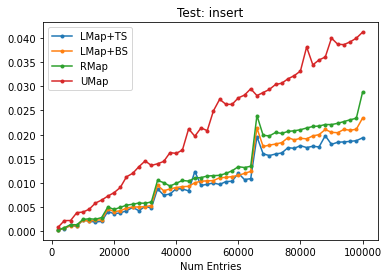

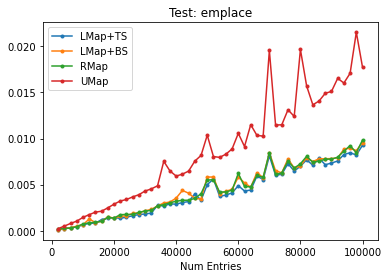

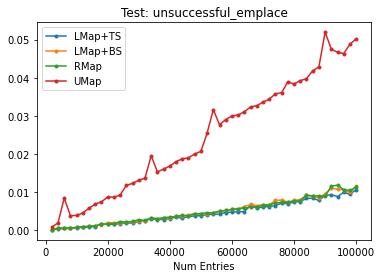

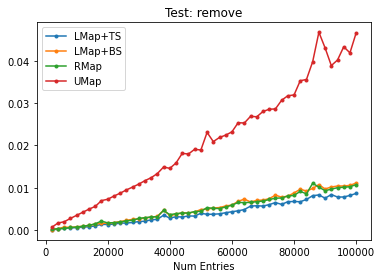

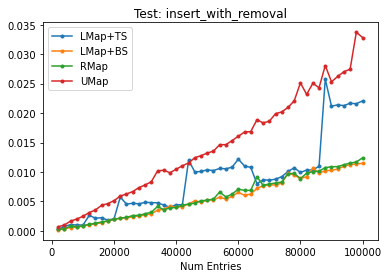

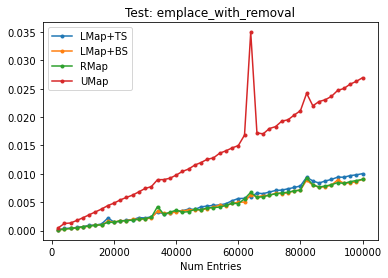

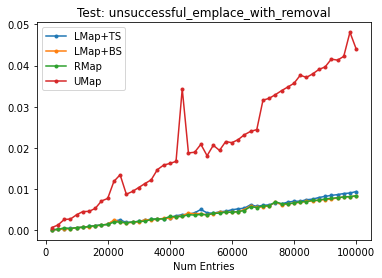

In [9]:
for name in graph_names:
    fig = pds[name].plot(x = 'Num Entries', y = hashmap_names, title = "Test: {}".format(name), style='.-')
    plt.savefig('../static/{}.jpg'.format(name))

## Final Thoughts

On average, my open-addressed hashmaps outperform C++'s *std::unordered_map* in every benchmark by a factor of 2 or 3. In addition, based on the graphs, the best hashmap is *LinearMap* with backwards shifting. This is curious to me because all online resources tell me that Robinhood hashing should be a strict improvement over pure linear probing. However, that statement could be true only with tombstones instead of actual backwards shifting. I haven't found any benchmarks with linear probe hashmaps that use backwards shifting instead of tombstones.

So will I be using my *LinearMap* with backwards shifting in the future? I'd like to think so, but I also know there are even faster implementations out there, like any of the hashmaps from [Malte Skarupke](https://probablydance.com/2017/02/26/i-wrote-the-fastest-hashtable/) and Google's [abseil::flat_hash_map](https://github.com/abseil/abseil-cpp/blob/master/absl/container/flat_hash_map.h). Either way, I'm pretty happy with the performance of my open-addressed hashmaps!